In [1]:
import warnings

warnings.filterwarnings('ignore')

In [2]:
import pandas as pd
import re
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
from sklearn.model_selection import train_test_split, StratifiedShuffleSplit
from sklearn.metrics import accuracy_score, f1_score, classification_report, roc_auc_score, confusion_matrix, recall_score, precision_score
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader, TensorDataset
import torch.optim as optim
from torch.nn.utils.rnn import pad_sequence
import math
from pprint import pprint
from collections import Counter
import gensim


from sklearn.utils.class_weight import compute_class_weight
tqdm.pandas()

In [3]:
# Set the seed for NumPy
np.random.seed(1337)

# Set the seed for PyTorch
torch.manual_seed(1337)

# If using CUDA (PyTorch)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(1337)

In [4]:
df = pd.read_csv('data_m.csv')

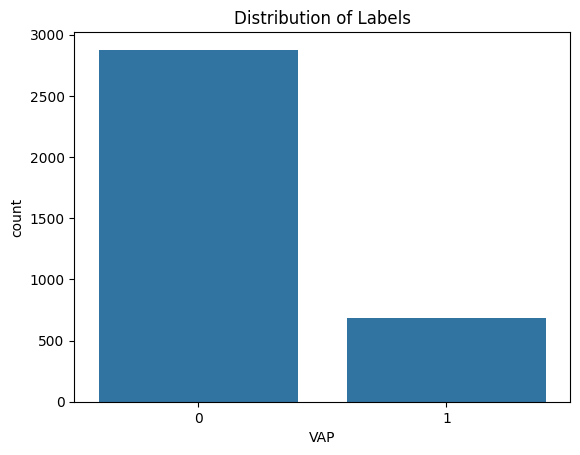

In [5]:
sns.countplot(x='VAP', data=df)
plt.title('Distribution of Labels')
plt.show()

In [6]:
# data_0 = data[data['VAP'] == 0]
# data_1 = data[data['VAP'] == 1]

# # Count word frequencies in each class
# counter_0 = Counter(word for text in data_0['TEXT'] for word in text.split())
# counter_1 = Counter(word for text in data_1['TEXT'] for word in text.split())

# # Find words that are common to both classes
# common_words = set(counter_0.keys()).intersection(counter_1.keys())

# # Set the threshold for word removal
# threshold = 0.2

# # Determine words to remove based on their frequency ratio
# words_to_remove = {
#     word for word in common_words
#     if 1 - threshold <= (counter_1[word] / data_1.shape[0]) / (counter_0[word] / data_0.shape[0]) <= 1 + threshold
# }

# # Function to remove selected words
# def remove_selected_words(text):
#     return ' '.join(word for word in text.split() if word not in words_to_remove)

# # Apply the function to the 'TEXT' column
# data['TEXT'] = data['TEXT'].progress_apply(remove_selected_words)

In [7]:
def clean_text(text):
    text = re.sub(r'[^a-zA-Z]', ' ', text)
    text = re.sub(r'\s+', ' ', text)
    return text

df['TEXT'] = df['TEXT'].progress_apply(clean_text)

100%|██████████| 3558/3558 [00:48<00:00, 73.76it/s] 


In [8]:
# remove rows with empty text
df = df[df['TEXT'] != '']

# reindex the dataframe
df = df.reset_index(drop=True)

<Axes: ylabel='count'>

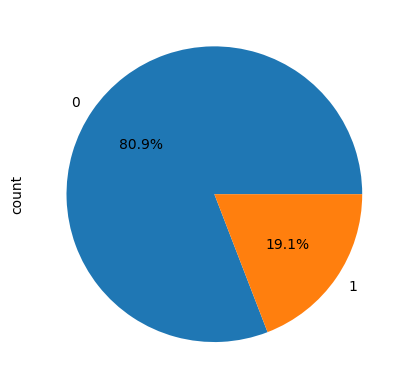

In [9]:
# # create a new dataframe that contains as much data from each class as the number of rows in the class with the least rows
# data_balanced = pd.concat([data[data['VAP'] == 0].sample(data[data['VAP'] == 1].shape[0], random_state=42), data[data['VAP'] == 1]])
# data = data_balanced
# pie chart of Label
df['VAP'].value_counts().plot.pie(autopct='%1.1f%%')

In [10]:
# Load the embedding model
embedding_model = gensim.models.KeyedVectors.load_word2vec_format("bio.bin", binary=True)

# Create a set of words present in the embedding model for faster lookup
words_in_model = set(embedding_model.key_to_index)

# Function to calculate the average number of words per text
def average_words(text_series):
    return text_series.str.split().apply(lambda words: len([word for word in words if word in words_in_model])).mean()

# Calculate averages
average_words_per_text = average_words(df['TEXT'])
print(f'Average words per text: {average_words_per_text}')

average_words_per_text_class_0 = average_words(df[df['VAP'] == 0]['TEXT'])
print(f'Average words per text class 0: {average_words_per_text_class_0}')

average_words_per_text_class_1 = average_words(df[df['VAP'] == 1]['TEXT'])
print(f'Average words per text class 1: {average_words_per_text_class_1}')

Average words per text: 27222.171444631815
Average words per text class 0: 33292.13312478276
Average words per text class 1: 1578.588839941263


In [11]:
chunk_size = 32
max_chunks = 768

In [12]:
# creating a matrix of word embeddings using the cleaned data and the BioWordVec model
embedding_model = gensim.models.KeyedVectors.load_word2vec_format("bio.bin", binary=True)
embed_dim = embedding_model.vector_size

def split_into_chunks(text, chunk_size=200):
    words = text.split()
    return [' '.join(words[i:i+chunk_size]) for i in range(0, len(words), chunk_size)]

def average_embeddings_for_chunk(chunk, embedding_model):
    embeddings = []
    for word in chunk.split():
        try:
            embeddings.append(embedding_model[word])
        except KeyError:
            pass
    if embeddings:
        return np.mean(embeddings, axis=0)
    else:
        return np.zeros(embedding_model.vector_size)  # Return zero vector if no words found

def process_text(text, embedding_model, chunk_size=200, max_chunks=256):
    chunks = split_into_chunks(text, chunk_size)
    chunk_embeddings = [average_embeddings_for_chunk(chunk, embedding_model) for chunk in chunks[:max_chunks]]
    # Pad with zeros if there are fewer chunks than max_chunks
    while len(chunk_embeddings) < max_chunks:
        chunk_embeddings.append(np.zeros(embedding_model.vector_size))
    return chunk_embeddings

# Apply the processing to each row in the DataFrame
chunks_of_embeddings = df['TEXT'].progress_apply(lambda text: process_text(text, embedding_model, chunk_size, max_chunks))

100%|██████████| 3558/3558 [00:50<00:00, 69.98it/s] 


In [13]:
# Separate the data by class
class_0 = chunks_of_embeddings[df['VAP'] == 0]
class_1 = chunks_of_embeddings[df['VAP'] == 1]

# Determine the number of samples per class for the training set (15% of total df for each class)
n_samples = int(0.10 * len(chunks_of_embeddings))

# Sample from each class
train_0 = class_0.sample(n=n_samples, random_state=42)
train_1 = class_1.sample(n=n_samples, random_state=42)

# Combine to form the training set
X_train = pd.concat([train_0, train_1])
y_train = df['VAP'].loc[X_train.index]

# Remove the training df from the dfset
remaining_data = chunks_of_embeddings.drop(X_train.index)
remaining_target = df['VAP'].drop(X_train.index)

# Split the remaining data into validation and test sets (50-50 split)
X_val, X_test, y_val, y_test = train_test_split(remaining_data, remaining_target, test_size=0.95, random_state=42, stratify=remaining_target)

In [14]:
print(f'Number of training samples: {len(X_train)}')
print(f'Number of validation samples: {len(X_val)}')
print(f'Number of test samples: {len(X_test)}')

Number of training samples: 710
Number of validation samples: 142
Number of test samples: 2706


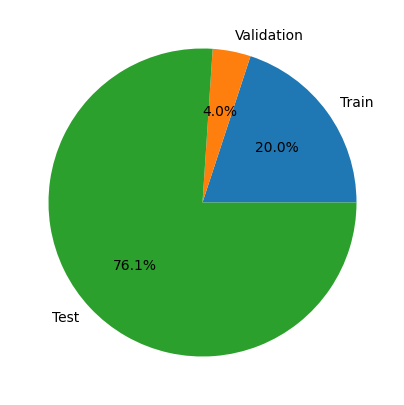

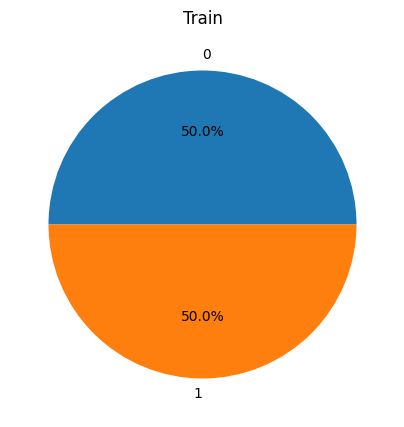

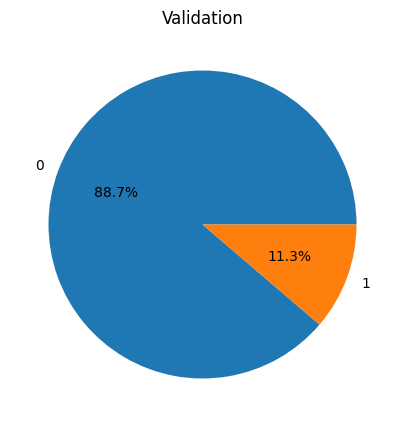

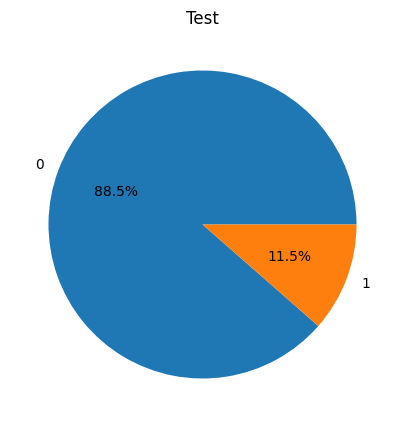

In [15]:
#plot the distribution of the training set validation set and test set in a single pie chart and in each split i want you to show how 
plt.figure(figsize=(5, 5))
plt.pie([len(X_train), len(X_val), len(X_test)], labels=['Train', 'Validation', 'Test'], autopct='%1.1f%%')
plt.show()

# plot how many of each class is in each split
plt.figure(figsize=(5, 5))
plt.pie([y_train.value_counts()[0], y_train.value_counts()[1]], labels=['0', '1'], autopct='%1.1f%%')
plt.title('Train')
plt.show()

plt.figure(figsize=(5, 5))
plt.pie([y_val.value_counts()[0], y_val.value_counts()[1]], labels=['0', '1'], autopct='%1.1f%%')
plt.title('Validation')
plt.show()

plt.figure(figsize=(5, 5))
plt.pie([y_test.value_counts()[0], y_test.value_counts()[1]], labels=['0', '1'], autopct='%1.1f%%')
plt.title('Test')
plt.show()

In [16]:
d

NameError: name 'd' is not defined

In [ ]:
# Function to convert embeddings and labels to tensors
def embeddings_to_tensor(embeddings):
    return torch.tensor(embeddings, dtype=torch.float32)

# Convert embeddings and labels to tensors
X_train_tensor = embeddings_to_tensor(X_train.to_list())
X_val_tensor = embeddings_to_tensor(X_val.to_list())
X_test_tensor = embeddings_to_tensor(X_test.to_list())

y_train_tensor = torch.tensor(y_train.values, dtype=torch.long)
y_val_tensor = torch.tensor(y_val.values, dtype=torch.long)
y_test_tensor = torch.tensor(y_test.values, dtype=torch.long)

In [ ]:
train_data = TensorDataset(X_train_tensor, y_train_tensor)
val_data = TensorDataset(X_val_tensor, y_val_tensor)
test_data = TensorDataset(X_test_tensor, y_test_tensor)

batch_size = 32

train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_data, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_data, batch_size=batch_size, shuffle=False)

In [ ]:
class TransformerBlock(nn.Module):
    def __init__(self, embed_dim, num_heads, ff_dim, dropout=0.5):
        super(TransformerBlock, self).__init__()
        self.att = nn.MultiheadAttention(embed_dim, num_heads)
        self.ffn = nn.Sequential(
            nn.Linear(embed_dim, ff_dim),
            nn.ReLU(),
            nn.Linear(ff_dim, embed_dim),
        )
        self.layernorm1 = nn.LayerNorm(embed_dim, eps=1e-6)
        self.layernorm2 = nn.LayerNorm(embed_dim, eps=1e-6)
        self.dropout1 = nn.Dropout(dropout)
        self.dropout2 = nn.Dropout(dropout)

    def forward(self, inputs):
        # Permute to [sequence_length, batch_size, hidden_size]
        inputs_perm = inputs.permute(1, 0, 2)
        attn_output, _ = self.att(inputs_perm, inputs_perm, inputs_perm)
        # Back to [batch_size, sequence_length, hidden_size]
        attn_output = attn_output.permute(1, 0, 2)
        attn_output = self.dropout1(attn_output)
        out1 = self.layernorm1(inputs + attn_output)
        ffn_output = self.ffn(out1)
        ffn_output = self.dropout2(ffn_output)
        return self.layernorm2(out1 + ffn_output)

class TextClassificationModel(nn.Module):
    def __init__(self, embed_dim, num_heads, ff_dim, max_seq_len, dropout=0.7, num_transformer_blocks=2):
        super(TextClassificationModel, self).__init__()
        
        # Creating multiple Transformer Blocks
        self.transformer_blocks = nn.ModuleList([
            TransformerBlock(embed_dim, num_heads, ff_dim)
            for _ in range(num_transformer_blocks)
        ])
        
        # Pooling Layer
        self.pooling = nn.AdaptiveAvgPool1d(1)

        # Additional Linear, BatchNorm, and Dropout Layers
        self.fc1 = nn.Linear(embed_dim, embed_dim // 2)
        self.batch_norm = nn.BatchNorm1d(embed_dim // 2)
        self.dropout = nn.Dropout(dropout)

        # Final Fully Connected Layer for Classification
        self.fc2 = nn.Linear(embed_dim // 2, 1)
        
        # Positional Encoding Layer
        self.positional_encoding = self.create_positional_encoding(max_seq_len, embed_dim)
    
    
    def forward(self, x):
        seq_len = x.size(1)

        # Get the positional encoding for the sequence length
        scaled_pos_encoding = self.positional_encoding[:seq_len, :]
        scaled_pos_encoding = scaled_pos_encoding.to(x.device)
        scaled_pos_encoding = scaled_pos_encoding.unsqueeze(0).expand(x.size(0), -1, -1)

        # Adding positional encoding
        x = x + scaled_pos_encoding

        # Passing input through each Transformer block sequentially
        for transformer_block in self.transformer_blocks:
            x = transformer_block(x)
        
        # Pooling
        x = x.permute(0, 2, 1)  
        x = self.pooling(x).squeeze(-1)
        
        # Passing through the first linear layer, batch norm, and dropout
        x = F.relu(self.fc1(x))
        x = self.batch_norm(x)
        x = self.dropout(x)

        # Final Classification
        x = self.fc2(x)
        return x

    def create_positional_encoding(self, max_seq_len, embed_dim):
        position = torch.arange(0, max_seq_len, dtype=torch.float).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, embed_dim, 2).float() * (-math.log(10000.0) / embed_dim))
        positional_encoding = torch.zeros(max_seq_len, embed_dim)
        positional_encoding[:, 0::2] = torch.sin(position * div_term)
        positional_encoding[:, 1::2] = torch.cos(position * div_term)
        return positional_encoding

In [ ]:
# define the device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# # Calculate class weights
# class_weight = compute_class_weight('balanced', classes=[0, 1], y=y_train)
# class_weight_ratio = class_weight[1] / class_weight[0]
# class_weights_tensor = torch.tensor(class_weight_ratio, dtype=torch.float32, device=device)

# Update the loss function to include class weights
criterion = nn.BCEWithLogitsLoss()

max_seq_len = max_chunks
epochs = 25

In [ ]:
# from hyperopt import fmin, tpe, hp, STATUS_OK, Trials
# import json

# # Define a global variable for the log file
# log_file_path = "hyperopt_log.txt"

# # Define the objective function
# def objective(params):
#     with open(log_file_path, "a") as log_file:
#         log_file.write(f"Trial params: {json.dumps(params)}\n")
    
#     model = TextClassificationModel(
#         embed_dim,
#         int(params['num_heads']),
#         int(params['ff_dim']),
#         max_seq_len,
#         params['dropout'],
#         int(params['num_transformer_blocks'])
#     ).to(device)

#     criterion = nn.BCEWithLogitsLoss()
#     optimizer = optim.AdamW(model.parameters(), lr=params['learning_rate'], weight_decay=params['weight_decay'])

#     for epoch in range(epochs):
#         model.train()
#         total_train_loss = 0

#         for X_batch, y_batch in train_loader:
#             X_batch, y_batch = X_batch.to(device), y_batch.to(device)

#             optimizer.zero_grad()
#             y_pred = model(X_batch).squeeze()
#             loss = criterion(y_pred, y_batch.float())
#             loss.backward()
#             optimizer.step()
#             total_train_loss += loss.item()

#         model.eval()
#         total_val_loss = 0
#         total_val_accuracy = 0
#         total_val_f1 = 0

#         with torch.no_grad():
#             for X_batch, y_batch in test_loader:
#                 X_batch, y_batch = X_batch.to(device), y_batch.to(device)
#                 y_pred = model(X_batch).squeeze()
#                 loss = criterion(y_pred, y_batch.float())
#                 total_val_loss += loss.item()

#                 y_pred = torch.sigmoid(y_pred)
#                 y_pred = torch.round(y_pred)
#                 total_val_accuracy += accuracy_score(y_batch.tolist(), y_pred.tolist())
#                 total_val_f1 += f1_score(y_batch.tolist(), y_pred.tolist())

#         avg_val_loss = total_val_loss / len(test_loader)
#         avg_val_accuracy = total_val_accuracy / len(test_loader)
#         avg_val_f1 = total_val_f1 / len(test_loader)
        
#     with open(log_file_path, "a") as log_file:
#         log_file.write(f"Loss: {avg_val_loss}, Accuracy: {avg_val_accuracy}, F1: {avg_val_f1}\n")
    
#     return {'loss': avg_val_loss, 'status': STATUS_OK}

# # Define the hyperparameter space
# space = {
#     'num_heads': hp.choice('num_heads', [2, 4, 8]),
#     'ff_dim': hp.uniform('ff_dim', 8, 128),
#     'dropout': hp.uniform('dropout', 0.1, 0.9),
#     'learning_rate': hp.loguniform('learning_rate', -7, -2),
#     'weight_decay': hp.loguniform('weight_decay', -7, -2),
#     'num_transformer_blocks': hp.choice('num_transformer_blocks', [1, 2, 3])
# }

# # Run the optimization
# trials = Trials()
# best = fmin(fn=objective, space=space, algo=tpe.suggest, max_evals=100, trials=trials)

# print("Best Hyperparameters:", best)

In [ ]:
num_heads = 8
ff_dim = 32
max_seq_len = max_chunks
dropout = 0.5
num_transformer_blocks = 2
learning_rate = 0.0001
weight_decay = 0.002

# num_heads_choices = [2, 4, 8]
# num_transformer_blocks_choices = [1, 2, 3]


# num_heads = num_heads_choices[best['num_heads']]
# num_transformer_blocks = num_transformer_blocks_choices[best['num_transformer_blocks']]

# ff_dim = int(best['ff_dim'])
# dropout = round(best['dropout'], 2)
# learning_rate = best['learning_rate']
# weight_decay = best['weight_decay']

# Create the model with the correct hyperparameters
model = TextClassificationModel(embed_dim, num_heads, ff_dim, max_seq_len, dropout, num_transformer_blocks)
model = model.to(device)

# Define the optimizer
optimizer = optim.AdamW(filter(lambda p: p.requires_grad, model.parameters()), lr=learning_rate, weight_decay=weight_decay)


model

TextClassificationModel(
  (transformer_blocks): ModuleList(
    (0-1): 2 x TransformerBlock(
      (att): MultiheadAttention(
        (out_proj): NonDynamicallyQuantizableLinear(in_features=200, out_features=200, bias=True)
      )
      (ffn): Sequential(
        (0): Linear(in_features=200, out_features=32, bias=True)
        (1): ReLU()
        (2): Linear(in_features=32, out_features=200, bias=True)
      )
      (layernorm1): LayerNorm((200,), eps=1e-06, elementwise_affine=True)
      (layernorm2): LayerNorm((200,), eps=1e-06, elementwise_affine=True)
      (dropout1): Dropout(p=0.5, inplace=False)
      (dropout2): Dropout(p=0.5, inplace=False)
    )
  )
  (pooling): AdaptiveAvgPool1d(output_size=1)
  (fc1): Linear(in_features=200, out_features=100, bias=True)
  (batch_norm): BatchNorm1d(100, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (dropout): Dropout(p=0.5, inplace=False)
  (fc2): Linear(in_features=100, out_features=1, bias=True)
)

In [ ]:
print("Using device:", device)

transformer_result = {}
transformer_result['loss'] = {}
transformer_result['accuracy'] = {}
transformer_result['f1'] = {}
transformer_result['loss']['train'] = []
transformer_result['loss']['val'] = []
transformer_result['accuracy']['train'] = []
transformer_result['accuracy']['val'] = []
transformer_result['f1']['train'] = []
transformer_result['f1']['val'] = []


for epoch in range(epochs):
    
    print('-' * 10)
    
    total_train_loss = 0
    total_train_accuracy = 0
    total_train_f1 = 0
    
    model.train()

    progress_bar = tqdm(enumerate(train_loader), total=len(train_loader))
    
    for i, batch in progress_bar:
        progress_bar.set_description(f'[Training] Epoch {epoch}]')
        
        optimizer.zero_grad()
        
        X_batch, y_batch = batch
        X_batch = X_batch.to(device)
        y_batch = y_batch.to(device)
        
        y_pred = model(X_batch).squeeze() 
        
        loss = criterion(y_pred, y_batch.float())
        
        loss.backward()
        optimizer.step()
        
        y_pred = torch.sigmoid(y_pred)
        y_pred = torch.round(y_pred)

        total_train_loss += loss.item()
        total_train_accuracy += accuracy_score(y_batch.tolist(), y_pred.detach().cpu().numpy().tolist())
        total_train_f1 += f1_score(y_batch.tolist(), y_pred.detach().cpu().numpy().tolist(), average='weighted')
        
        progress_bar.set_postfix({'training_loss': total_train_loss / (i + 1), 'training_accuracy': total_train_accuracy / (i + 1), 'training_f1': total_train_f1 / (i + 1)})
        
    transformer_result['loss']['train'].append(total_train_loss / len(train_loader))
    transformer_result['accuracy']['train'].append(total_train_accuracy / len(train_loader))
    transformer_result['f1']['train'].append(total_train_f1 / len(train_loader))
        
    total_val_loss = 0
    total_val_accuracy = 0
    total_val_f1 = 0

    model.eval()
    
    progress_bar = tqdm(enumerate(val_loader), total=len(val_loader))
    
    for i, batch in progress_bar:
        progress_bar.set_description(f'[Validation] Epoch {epoch}]')
        
        X_batch, y_batch = batch
        X_batch = X_batch.to(device)
        y_batch = y_batch.to(device)
        
        with torch.no_grad():
            y_pred = model(X_batch).squeeze() 
        
        loss = criterion(y_pred, y_batch.float())
        
        y_pred = torch.sigmoid(y_pred)
        y_pred = torch.round(y_pred)
        
        total_val_loss += loss.item()
        total_val_accuracy += accuracy_score(y_batch.tolist(), y_pred.tolist())
        total_val_f1 += f1_score(y_batch.tolist(), y_pred.tolist(), average='weighted')
        
        progress_bar.set_postfix({'validation_loss': total_val_loss / (i + 1), 'validation_accuracy': total_val_accuracy / (i + 1), 'validation_f1': total_val_f1 / (i + 1)})
        
    transformer_result['loss']['val'].append(total_val_loss / len(val_loader))
    transformer_result['accuracy']['val'].append(total_val_accuracy / len(val_loader))
    transformer_result['f1']['val'].append(total_val_f1 / len(val_loader))

Using device: cuda
----------


[Validation] Epoch 0]: 100%|██████████| 5/5 [00:00<00:00, 23.62it/s, validation_loss=0.527, validation_accuracy=0.865, validation_f1=0.884]


----------


[Validation] Epoch 1]: 100%|██████████| 5/5 [00:00<00:00, 23.54it/s, validation_loss=0.349, validation_accuracy=0.859, validation_f1=0.881]


----------


[Validation] Epoch 2]: 100%|██████████| 5/5 [00:00<00:00, 23.46it/s, validation_loss=0.227, validation_accuracy=0.919, validation_f1=0.927]


----------


[Validation] Epoch 3]: 100%|██████████| 5/5 [00:00<00:00, 23.61it/s, validation_loss=0.181, validation_accuracy=0.944, validation_f1=0.948]


----------


[Validation] Epoch 4]: 100%|██████████| 5/5 [00:00<00:00, 23.70it/s, validation_loss=0.173, validation_accuracy=0.963, validation_f1=0.968]


----------


[Validation] Epoch 5]: 100%|██████████| 5/5 [00:00<00:00, 23.68it/s, validation_loss=0.127, validation_accuracy=0.988, validation_f1=0.988]


----------


[Validation] Epoch 6]: 100%|██████████| 5/5 [00:00<00:00, 23.68it/s, validation_loss=0.113, validation_accuracy=0.988, validation_f1=0.988]


----------


[Validation] Epoch 7]: 100%|██████████| 5/5 [00:00<00:00, 23.34it/s, validation_loss=0.106, validation_accuracy=0.988, validation_f1=0.988]


----------


[Validation] Epoch 8]: 100%|██████████| 5/5 [00:00<00:00, 23.56it/s, validation_loss=0.126, validation_accuracy=0.988, validation_f1=0.988]


----------


[Validation] Epoch 9]: 100%|██████████| 5/5 [00:00<00:00, 23.23it/s, validation_loss=0.119, validation_accuracy=0.981, validation_f1=0.982]


----------


[Validation] Epoch 10]: 100%|██████████| 5/5 [00:00<00:00, 23.45it/s, validation_loss=0.0871, validation_accuracy=0.988, validation_f1=0.988]


----------


[Validation] Epoch 11]: 100%|██████████| 5/5 [00:00<00:00, 23.21it/s, validation_loss=0.17, validation_accuracy=0.95, validation_f1=0.956]  


----------


[Validation] Epoch 12]: 100%|██████████| 5/5 [00:00<00:00, 23.24it/s, validation_loss=0.0519, validation_accuracy=0.988, validation_f1=0.988]


----------


[Validation] Epoch 13]: 100%|██████████| 5/5 [00:00<00:00, 22.34it/s, validation_loss=0.0579, validation_accuracy=0.988, validation_f1=0.988]


----------


[Validation] Epoch 14]: 100%|██████████| 5/5 [00:00<00:00, 23.52it/s, validation_loss=0.0767, validation_accuracy=0.981, validation_f1=0.982]


----------


[Validation] Epoch 15]: 100%|██████████| 5/5 [00:00<00:00, 23.12it/s, validation_loss=0.0416, validation_accuracy=0.994, validation_f1=0.994]


----------


[Validation] Epoch 16]: 100%|██████████| 5/5 [00:00<00:00, 23.53it/s, validation_loss=0.0463, validation_accuracy=0.994, validation_f1=0.994]


----------


[Validation] Epoch 17]: 100%|██████████| 5/5 [00:00<00:00, 22.97it/s, validation_loss=0.0445, validation_accuracy=0.994, validation_f1=0.994]


----------


[Validation] Epoch 18]: 100%|██████████| 5/5 [00:00<00:00, 23.04it/s, validation_loss=0.0317, validation_accuracy=0.994, validation_f1=0.994]


----------


[Validation] Epoch 19]: 100%|██████████| 5/5 [00:00<00:00, 22.90it/s, validation_loss=0.0423, validation_accuracy=0.981, validation_f1=0.98] 


----------


[Validation] Epoch 20]: 100%|██████████| 5/5 [00:00<00:00, 23.03it/s, validation_loss=0.0482, validation_accuracy=0.988, validation_f1=0.988]


----------


[Validation] Epoch 21]: 100%|██████████| 5/5 [00:00<00:00, 22.73it/s, validation_loss=0.0303, validation_accuracy=0.994, validation_f1=0.994]


----------


[Validation] Epoch 22]: 100%|██████████| 5/5 [00:00<00:00, 23.21it/s, validation_loss=0.0584, validation_accuracy=0.981, validation_f1=0.982]


----------


[Validation] Epoch 23]: 100%|██████████| 5/5 [00:00<00:00, 23.28it/s, validation_loss=0.044, validation_accuracy=0.994, validation_f1=0.994] 


----------


[Validation] Epoch 24]: 100%|██████████| 5/5 [00:00<00:00, 23.07it/s, validation_loss=0.027, validation_accuracy=0.994, validation_f1=0.994]


Testing: 100%|██████████| 85/85 [00:03<00:00, 21.27it/s, testing_loss=0.0479]


Testing Accuracy: 0.9848484848484849
Testing F1 Score: 0.9849834612912415
              precision    recall  f1-score   support

           0       0.99      0.99      0.99      2396
           1       0.92      0.95      0.94       310

    accuracy                           0.98      2706
   macro avg       0.96      0.97      0.96      2706
weighted avg       0.99      0.98      0.98      2706



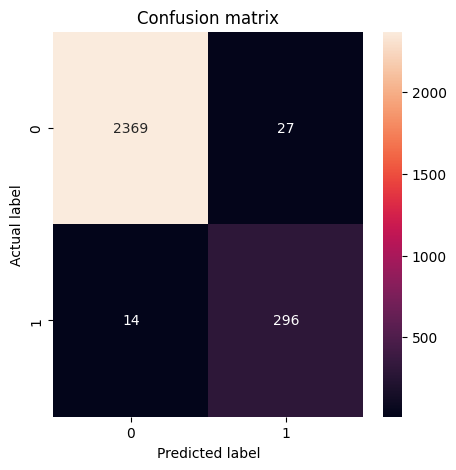

In [ ]:
# test the model
model.eval()

total_loss = 0
all_labels = []
all_predictions = []

progress_bar = tqdm(enumerate(test_loader), total=len(test_loader))

for i, batch in progress_bar:
    progress_bar.set_description('Testing')
    
    X_batch, y_batch = batch
    X_batch = X_batch.to(device)
    y_batch = y_batch.to(device)
    
    with torch.no_grad():
        y_pred = model(X_batch).squeeze() 
    
    loss = criterion(y_pred, y_batch.float())
    
    y_pred = torch.sigmoid(y_pred)
    y_pred = torch.round(y_pred)
    
    all_labels.extend(y_batch.tolist())
    all_predictions.extend(y_pred.tolist())
    
    total_loss += loss.item()
    
    progress_bar.set_postfix({'testing_loss': total_loss / (i + 1)})

# Calculate and print metrics after the loop
total_accuracy = accuracy_score(all_labels, all_predictions)
total_f1_weighted = f1_score(all_labels, all_predictions, average='weighted')

transformer_result['loss']['test'] = total_loss / len(test_loader)
transformer_result['accuracy']['test'] = total_accuracy
transformer_result['f1']['test'] = total_f1_weighted

print(f'Testing Accuracy: {total_accuracy}')
print(f'Testing F1 Score: {total_f1_weighted}')
print(classification_report(all_labels, all_predictions))

In [ ]:
# Confusion matrix
cm = confusion_matrix(all_labels, all_predictions)
plt.figure(figsize=(5, 5))
sns.heatmap(cm, annot=True, fmt="d")
plt.title('Confusion matrix')
plt.ylabel('Actual label')
plt.xlabel('Predicted label')
plt.show()

In [ ]:
class LSTMModel(nn.Module):
    def __init__(self, input_size, hidden_size, output_size, num_layers=1, bidirectional=False, dropout_rate=0.5):
        super(LSTMModel, self).__init__()
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers=num_layers, bidirectional=bidirectional, batch_first=True)
        self.dropout = nn.Dropout(dropout_rate)
        self.fc = nn.Linear(hidden_size * (2 if bidirectional else 1), output_size)

    def forward(self, x):
        lstm_out, _ = self.lstm(x)
        lstm_out = self.dropout(lstm_out[:, -1, :])  # Take the output from the last time step
        output = self.fc(lstm_out)
        return output

# Define hyperparameters for the LSTM model
lstm_hidden_size = 128
lstm_num_layers = 2
lstm_bidirectional = True
output_size = 1  # For binary classification, adjust if you have multiple classes
learning_rate = 0.001
weight_decay = 0.0002

# Create an instance of the LSTM model
lstm_model = LSTMModel(embed_dim, lstm_hidden_size, output_size, num_layers=lstm_num_layers, bidirectional=lstm_bidirectional)
lstm_model = lstm_model.to(device)

# Define optimizer and loss function
lstm_optimizer = optim.AdamW(lstm_model.parameters(), lr=learning_rate, weight_decay=weight_decay)
lstm_criterion = nn.BCEWithLogitsLoss()

In [ ]:
lstm_result = {}
lstm_result['loss'] = {}
lstm_result['accuracy'] = {}
lstm_result['f1'] = {}
lstm_result['loss']['train'] = []
lstm_result['loss']['val'] = []
lstm_result['accuracy']['train'] = []
lstm_result['accuracy']['val'] = []
lstm_result['f1']['train'] = []
lstm_result['f1']['val'] = []

# Training loop for the LSTM model
for epoch in range(epochs):
    
    print('-' * 10)
    
    total_train_loss = 0
    total_train_accuracy = 0
    total_train_f1 = 0
    
    lstm_model.train()  # Use lstm_model instead of model

    progress_bar = tqdm(enumerate(train_loader), total=len(train_loader))
    
    for i, batch in progress_bar:
        progress_bar.set_description(f'[Training] Epoch {epoch}]')
        
        lstm_optimizer.zero_grad()  # Use lstm_optimizer instead of optimizer
        
        X_batch, y_batch = batch
        X_batch = X_batch.to(device)
        y_batch = y_batch.to(device)
        
        y_pred = lstm_model(X_batch).squeeze()  # Use lstm_model instead of model
        
        loss = lstm_criterion(y_pred, y_batch.float())  # Use lstm_criterion instead of criterion
        
        loss.backward()
        lstm_optimizer.step()
        
        y_pred = torch.sigmoid(y_pred)
        y_pred = torch.round(y_pred)

        total_train_loss += loss.item()
        total_train_accuracy += accuracy_score(y_batch.tolist(), y_pred.detach().cpu().numpy().tolist())
        total_train_f1 += f1_score(y_batch.tolist(), y_pred.detach().cpu().numpy().tolist(), average='weighted')
        
        progress_bar.set_postfix({'training_loss': total_train_loss / (i + 1), 'training_accuracy': total_train_accuracy / (i + 1), 'training_f1': total_train_f1 / (i + 1)})
        
    lstm_result['loss']['train'].append(total_train_loss / len(train_loader))
    lstm_result['accuracy']['train'].append(total_train_accuracy / len(train_loader))
    lstm_result['f1']['train'].append(total_train_f1 / len(train_loader))
    
    total_val_loss = 0
    total_val_accuracy = 0
    total_val_f1 = 0
    
    lstm_model.eval()  # Use lstm_model instead of model
    
    progress_bar = tqdm(enumerate(val_loader), total=len(val_loader))
    
    for i, batch in progress_bar:
        progress_bar.set_description(f'[Validation] Epoch {epoch}]')
        
        X_batch, y_batch = batch
        X_batch = X_batch.to(device)
        y_batch = y_batch.to(device)
        
        with torch.no_grad():
            y_pred = lstm_model(X_batch).squeeze()
            
        loss = lstm_criterion(y_pred, y_batch.float())
        
        y_pred = torch.sigmoid(y_pred)
        y_pred = torch.round(y_pred)
        
        total_val_loss += loss.item()
        total_val_accuracy += accuracy_score(y_batch.tolist(), y_pred.tolist())
        total_val_f1 += f1_score(y_batch.tolist(), y_pred.tolist(), average='weighted')
        
        progress_bar.set_postfix({'validation_loss': total_val_loss / (i + 1), 'validation_accuracy': total_val_accuracy / (i + 1), 'validation_f1': total_val_f1 / (i + 1)})
        
    lstm_result['loss']['val'].append(total_val_loss / len(val_loader))
    lstm_result['accuracy']['val'].append(total_val_accuracy / len(val_loader))
    lstm_result['f1']['val'].append(total_val_f1 / len(val_loader))


----------


[Validation] Epoch 0]: 100%|██████████| 5/5 [00:00<00:00, 46.47it/s, validation_loss=0.535, validation_accuracy=0.572, validation_f1=0.644]


----------


[Validation] Epoch 1]: 100%|██████████| 5/5 [00:00<00:00, 45.96it/s, validation_loss=0.506, validation_accuracy=0.579, validation_f1=0.65]


----------


[Validation] Epoch 2]: 100%|██████████| 5/5 [00:00<00:00, 45.14it/s, validation_loss=0.506, validation_accuracy=0.593, validation_f1=0.664]


----------


[Validation] Epoch 3]: 100%|██████████| 5/5 [00:00<00:00, 46.59it/s, validation_loss=0.539, validation_accuracy=0.572, validation_f1=0.644]


----------


[Validation] Epoch 4]: 100%|██████████| 5/5 [00:00<00:00, 44.05it/s, validation_loss=0.509, validation_accuracy=0.572, validation_f1=0.644]


----------


[Validation] Epoch 5]: 100%|██████████| 5/5 [00:00<00:00, 43.86it/s, validation_loss=0.495, validation_accuracy=0.579, validation_f1=0.65]


----------


[Validation] Epoch 6]: 100%|██████████| 5/5 [00:00<00:00, 45.32it/s, validation_loss=0.316, validation_accuracy=0.876, validation_f1=0.819]


----------


[Validation] Epoch 7]: 100%|██████████| 5/5 [00:00<00:00, 45.94it/s, validation_loss=0.504, validation_accuracy=0.624, validation_f1=0.692]


----------


[Validation] Epoch 8]: 100%|██████████| 5/5 [00:00<00:00, 45.74it/s, validation_loss=0.537, validation_accuracy=0.579, validation_f1=0.65]


----------


[Validation] Epoch 9]: 100%|██████████| 5/5 [00:00<00:00, 45.60it/s, validation_loss=0.519, validation_accuracy=0.579, validation_f1=0.65]


----------


[Validation] Epoch 10]: 100%|██████████| 5/5 [00:00<00:00, 45.41it/s, validation_loss=0.496, validation_accuracy=0.593, validation_f1=0.664]


----------


[Validation] Epoch 11]: 100%|██████████| 5/5 [00:00<00:00, 46.38it/s, validation_loss=0.501, validation_accuracy=0.593, validation_f1=0.664]


----------


[Validation] Epoch 12]: 100%|██████████| 5/5 [00:00<00:00, 45.97it/s, validation_loss=0.494, validation_accuracy=0.612, validation_f1=0.681]


----------


[Validation] Epoch 13]: 100%|██████████| 5/5 [00:00<00:00, 44.83it/s, validation_loss=0.488, validation_accuracy=0.612, validation_f1=0.681]


----------


[Validation] Epoch 14]: 100%|██████████| 5/5 [00:00<00:00, 45.31it/s, validation_loss=0.481, validation_accuracy=0.612, validation_f1=0.681]


----------


[Validation] Epoch 15]: 100%|██████████| 5/5 [00:00<00:00, 45.90it/s, validation_loss=0.46, validation_accuracy=0.637, validation_f1=0.704]


----------


[Validation] Epoch 16]: 100%|██████████| 5/5 [00:00<00:00, 47.17it/s, validation_loss=0.561, validation_accuracy=0.572, validation_f1=0.644]


----------


[Validation] Epoch 17]: 100%|██████████| 5/5 [00:00<00:00, 46.23it/s, validation_loss=0.502, validation_accuracy=0.572, validation_f1=0.644]


----------


[Validation] Epoch 18]: 100%|██████████| 5/5 [00:00<00:00, 45.74it/s, validation_loss=0.493, validation_accuracy=0.572, validation_f1=0.644]


----------


[Validation] Epoch 19]: 100%|██████████| 5/5 [00:00<00:00, 46.01it/s, validation_loss=0.492, validation_accuracy=0.605, validation_f1=0.675]


----------


[Validation] Epoch 20]: 100%|██████████| 5/5 [00:00<00:00, 47.57it/s, validation_loss=0.394, validation_accuracy=0.743, validation_f1=0.788]


----------


[Validation] Epoch 21]: 100%|██████████| 5/5 [00:00<00:00, 45.85it/s, validation_loss=0.404, validation_accuracy=0.743, validation_f1=0.788]


----------


[Validation] Epoch 22]: 100%|██████████| 5/5 [00:00<00:00, 43.49it/s, validation_loss=0.509, validation_accuracy=0.724, validation_f1=0.774]


----------


[Validation] Epoch 23]: 100%|██████████| 5/5 [00:00<00:00, 46.01it/s, validation_loss=0.228, validation_accuracy=0.956, validation_f1=0.95]


----------


[Validation] Epoch 24]: 100%|██████████| 5/5 [00:00<00:00, 46.10it/s, validation_loss=0.266, validation_accuracy=0.931, validation_f1=0.936]


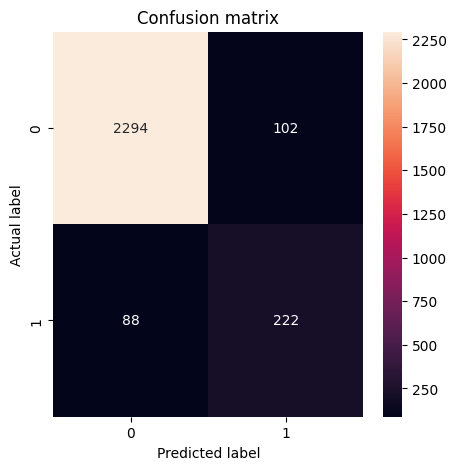

In [ ]:
# Confusion matrix
cm = confusion_matrix(lstm_all_labels, lstm_all_predictions)
plt.figure(figsize=(5, 5))
sns.heatmap(cm, annot=True, fmt="d")
plt.title('Confusion matrix')
plt.ylabel('Actual label')
plt.xlabel('Predicted label')
plt.show()

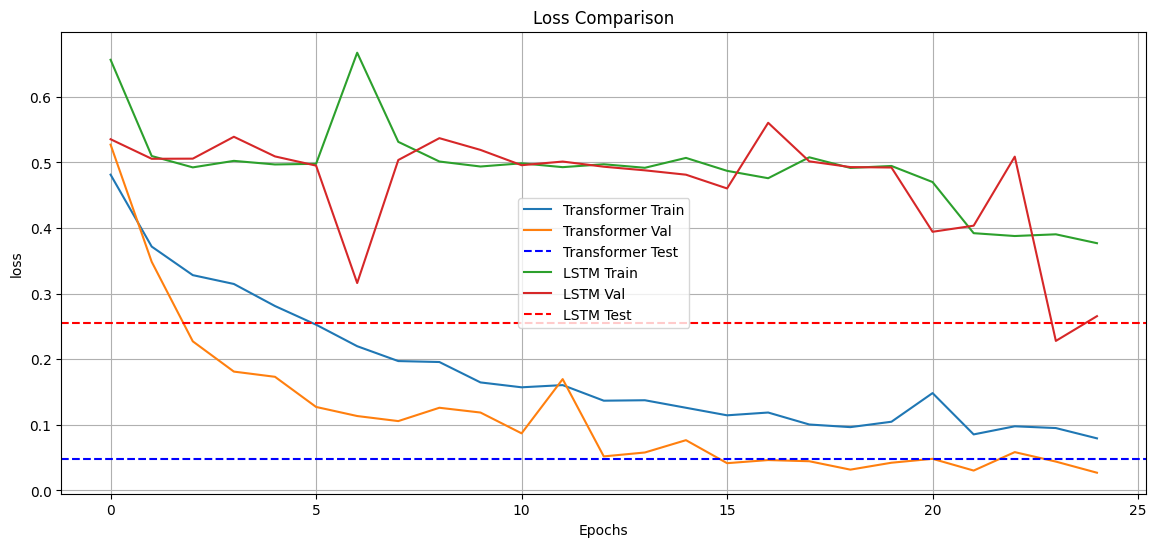

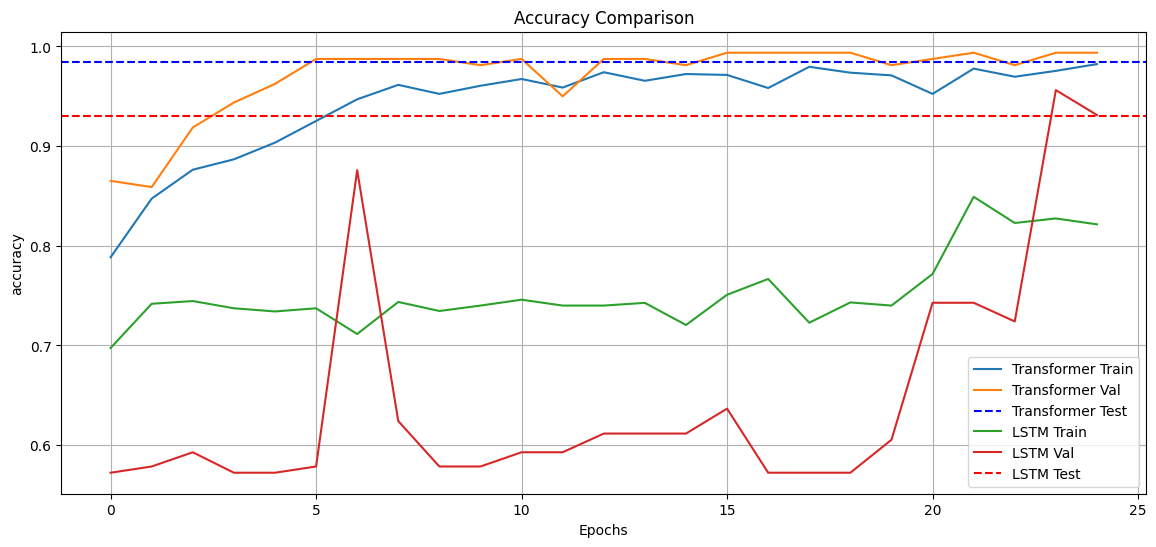

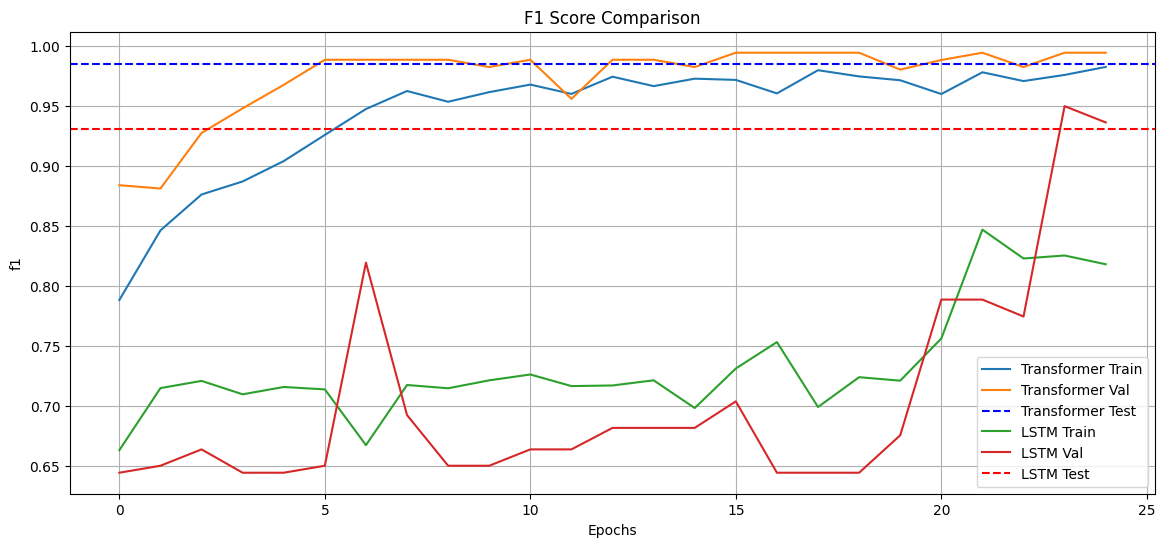

In [ ]:
# Function to plot training, validation, and test data for a given metric
def plot_metric_data(transformer_data, lstm_data, metric, title):
    plt.figure(figsize=(14, 6))

    # Plotting for Transformer model
    plt.plot(transformer_data[metric]['train'], label='Transformer Train')
    plt.plot(transformer_data[metric]['val'], label='Transformer Val')
    if 'test' in transformer_data[metric]:
        plt.axhline(y=transformer_data[metric]['test'], color='b', linestyle='--', label='Transformer Test')

    # Plotting for LSTM model
    plt.plot(lstm_data[metric]['train'], label='LSTM Train')
    plt.plot(lstm_data[metric]['val'], label='LSTM Val')
    if 'test' in lstm_data[metric]:
        plt.axhline(y=lstm_data[metric]['test'], color='r', linestyle='--', label='LSTM Test')

    plt.title(title)
    plt.xlabel('Epochs')
    plt.ylabel(metric)
    plt.legend()
    plt.grid(True)
    plt.show()

# Plotting Loss
plot_metric_data(transformer_result, lstm_result, 'loss', 'Loss Comparison')

# Plotting Accuracy
plot_metric_data(transformer_result, lstm_result, 'accuracy', 'Accuracy Comparison')

# Plotting F1 Score
plot_metric_data(transformer_result, lstm_result, 'f1', 'F1 Score Comparison')